In [2]:
import pandas as pd
import numpy as np 
import os
import matplotlib.pyplot as plt
import matplotlib.cm 
import matplotlib.colors
from matplotlib.patches import Patch
from selenobot.files import FASTAFile
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
import re

%load_ext autoreload
%autoreload 2

VAL_DIR = os.path.join('..', 'data', 'validation')
feature_types = ['plm', 'aa_1mer', 'aa_2mer', 'len']


# Evaluation on testing data

In [11]:
os.chdir('../scripts')

! python predict.py --input-path ../data/bac120_proteins_r207_subset_max_length_2000.h5 --type plm --n-classes 3 --add-metadata
# ! python predict.py --input-path ../data/bac120_proteins_r207_subset_max_length_2000.h5 --type len --n-classes 3
# ! python predict.py --input-path ../data/validation/bac120_proteins_r207_subset_max_length_2000.h5 --type aa_1mer --n-classes 3

! python predict.py --input-path ../data/bac120_proteins_r207_subset_max_length_2000.h5 --type plm --n-classes 2 --add-metadata
# ! python predict.py --input-path ../data/validation/bac120_proteins_r207_subset_max_length_2000.h5 --type len --n-classes 2
# ! python predict.py --input-path ../data/validation/bac120_proteins_r207_subset_max_length_2000.h5 --type aa_1mer --n-classes 2

Predictions written to ../data/results/predict_bac120_proteins_r207_subset_max_length_2000_ternary_model_plm.csv
Predictions written to ../data/results/predict_bac120_proteins_r207_subset_max_length_2000_binary_model_plm.csv


In [12]:
feature_types = ['plm']

# Read in the original metadata file, might be useful. 
gtdb_df = pd.read_csv('../data/bac120_proteins_r207_subset_max_length_2000.csv', index_col=0, dtype={'partial':str}) 

gtdb_ternary_results = dict()
gtdb_binary_results = dict()

for feature_type in feature_types:
    ternary_results_df = pd.read_csv(f'../data/results/predict_bac120_proteins_r207_subset_max_length_2000_ternary_model_{feature_type}.csv', index_col=0, dtype={'partial':str})
    ternary_results_df = ternary_results_df[ternary_results_df.partial.str.match('00')]
    gtdb_ternary_results[feature_type] = ternary_results_df

    binary_results_df = pd.read_csv(f'../data/results/predict_bac120_proteins_r207_subset_max_length_2000_binary_model_{feature_type}.csv', index_col=0, dtype={'partial':str})
    binary_results_df = binary_results_df[binary_results_df.partial.str.match('00')]
    gtdb_binary_results[feature_type] = binary_results_df

In [13]:
# What were the sequences predicted to be selenoproteins by the binary model predicted to be by the ternary model?
gtdb_binary_results_plm_df = gtdb_binary_results['plm']
gtdb_ternary_results_plm_df = gtdb_ternary_results['plm']

print('plm binary model - truncated selenoproteins:', (gtdb_binary_results_plm_df.prediction == 1).sum())
print('plm binary model - full-length:',(gtdb_binary_results_plm_df.prediction == 0).sum())
print()
print('plm ternary model - truncated non-selenoproteins:', (gtdb_ternary_results_plm_df.prediction == 2).sum())
print('plm ternary model - truncated selenoproteins:', (gtdb_ternary_results_plm_df.prediction == 1).sum())
print('plm ternary model - full-length:', (gtdb_ternary_results_plm_df.prediction == 0).sum())
print()

# binary_predicted_truncated_selenoproteins = gtdb_binary_results_plm_df[gtdb_binary_results_plm_df.prediction == 1].index

# for label, df in gtdb_ternary_results_plm_df[gtdb_ternary_results_plm_df.index.isin(binary_predicted_truncated_selenoproteins)].groupby('prediction'):
#     print(f'Label {label}:', len(df))

plm binary model - truncated selenoproteins: 18086
plm binary model - full-length: 442641

plm ternary model - truncated non-selenoproteins: 27933
plm ternary model - truncated selenoproteins: 12227
plm ternary model - full-length: 420567



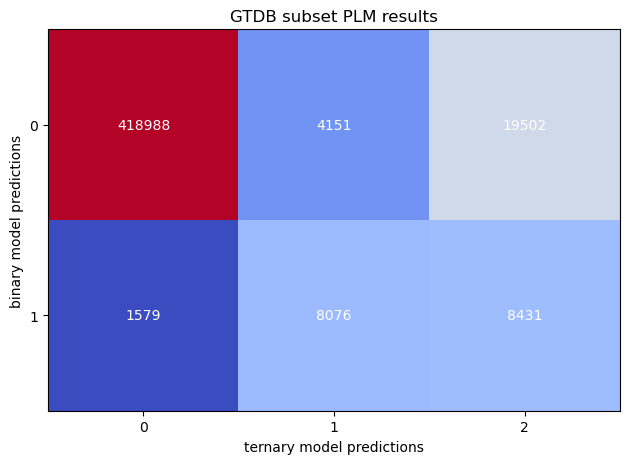

In [15]:
# print('len(gtdb_df) =', len(gtdb_df))
# print('len(gtdb_ternary_results_plm_df) =', len(gtdb_ternary_results_plm_df))
# print('len(gtdb_binary_results_plm_df) =', len(gtdb_binary_results_plm_df))

fig, ax = plt.subplots()
ax.set_yticks([0, 1]) # , labels=['fl', 'ts'])
ax.set_ylabel('binary model predictions')
ax.set_xticks([0, 1, 2]) # , labels=['fl', 'ts', 'tns'])
ax.set_xlabel('ternary model predictions')
ax.set_title('GTDB subset PLM results')

sizes = np.zeros((2, 3))
for binary_prediction, ternary_prediction in zip(gtdb_binary_results_plm_df.prediction, gtdb_ternary_results_plm_df.prediction):
    sizes[binary_prediction, ternary_prediction] += 1


ax.imshow(np.log(sizes), cmap='coolwarm') #, norm=norm)

for x in range(3):
    for y in range(2):
        text = ax.text(x, y, int(sizes[y, x]), ha='center', va='center', color='w')

plt.tight_layout()
plt.show()

# Based on the plot below, it seems as though the ternary model has a tendency to predict full-length
# sequences to be truncated non-selenoproteins. The ternary model also has the tendency to categorize truncated selenoproteins as 
# truncated non-selenoproteins. Both generally agree on the full-length sequences. 

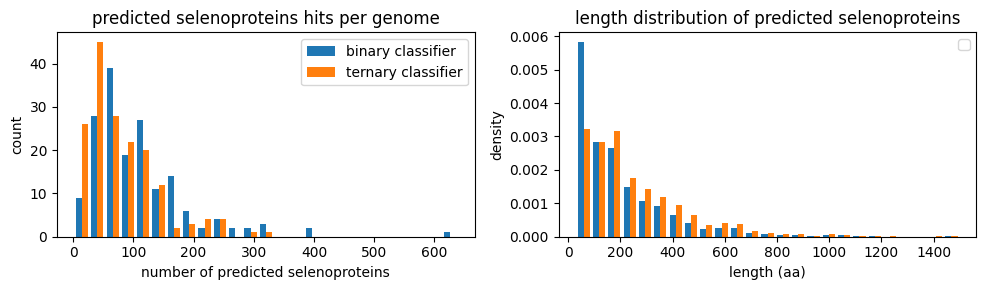

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 3))

hits_per_genome = []
length_distribution = []
legend = []

for df in [gtdb_binary_results['plm'], gtdb_ternary_results['plm']]:
    hits_per_genome.append(df[df.prediction == 1].groupby('genome_id').apply(len, include_groups=False))
    length_distribution.append(df[df.prediction == 1].length)
    
axes[0].hist(hits_per_genome, bins=25)
axes[0].set_xlabel('number of predicted selenoproteins')
axes[0].set_ylabel('count')
axes[0].set_title('predicted selenoproteins hits per genome')
axes[0].legend(['binary classifier', 'ternary classifier'])

# length_distribution.append(gtdb_results['plm'].length) # Add the background length distribution. 
axes[1].hist(length_distribution, density=True, bins=25) # , color=['tab:blue', 'tab:orange', 'tab:green', 'gray'])

axes[1].set_xlabel('length (aa)')
axes[1].set_ylabel('density')
axes[1].set_title('length distribution of predicted selenoproteins')
axes[1].legend(legend) #  + ['background'])

plt.tight_layout()
plt.show()
# Binary classifier seems to be picking up many more of the super short sequences as truncated selenoproteins.  